# Histopathologic Cancer Detection 


## Description of the problem and data

This project is based on the Kaggle Histopathologic Cancer Detection competition. The goal is to look at small square pictures (96x96 pixels) from pathology scans and decide if the very center (32x32 pixels) of the picture contains cancer tissue. It's a binary classification problem: label 1 means cancer is present in the center, label 0 means it's not.

The full training dataset has about 220,000 images, which is quite large. Each image is 96x96 pixels with 3 color channels (RGB). For this project, to make things faster, I'll use a smaller random sample (subset = 30k imgs) of the training data.

GitHub repo: [HERE](https://github.com/Dimi20cen/Histopathologic-Cancer-Detection)

## Setting up the Environment and Loading Data
First, let's import the libraries we'll need and set up the paths to the data. We'll also load the labels and take a look at them.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import random

print("TensorFlow Version:", tf.__version__)

# --- Configuration ---
SUBSET_SIZE = 30000 # Using 30k images for this run
IMG_SIZE = (96, 96)
INPUT_SHAPE = (96, 96, 3)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-3

# --- Path (Running in Kaggle) ---
DATA_DIR = '/kaggle/input/histopathologic-cancer-detection/'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
LABELS_FILE = os.path.join(DATA_DIR, 'train_labels.csv')

# --- Load Labels ---
labels_df_full = pd.read_csv(LABELS_FILE)
labels_df = labels_df_full.sample(SUBSET_SIZE, random_state=42)

# Prepare DataFrame for ImageDataGenerator
labels_df['filename'] = labels_df['id'].astype(str) + '.tif'
labels_df['label_str'] = labels_df['label'].astype(str)

print(f"Using {len(labels_df)} samples for this notebook.")


2025-04-27 18:48:40.384707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745779720.565165      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745779720.617737      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Using 30000 samples for this notebook.


## Exploratory Data Analysis

Let's explore the data subset we just loaded. We'll check:
* The first few rows of the label data.
* If there are any missing values.
* How many images have cancer (label 1) vs. no cancer (label 0).
* What some of the images actually look like.

First 5 rows of the subset labels:
                                              id  label  \
107796  d293308913e4a40cebb809d986aa9add65a76bfa      0   
11942   fcd55f03496afb4b11598d9c2231e86da318e723      1   
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957      0   
184810  71bf03e8530348e57ec07d8ce2052f215390c997      0   
150958  1533406000e26663c5fadac3bcc3e38285a45bb3      1   

                                            filename label_str  
107796  d293308913e4a40cebb809d986aa9add65a76bfa.tif         0  
11942   fcd55f03496afb4b11598d9c2231e86da318e723.tif         1  
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957.tif         0  
184810  71bf03e8530348e57ec07d8ce2052f215390c997.tif         0  
150958  1533406000e26663c5fadac3bcc3e38285a45bb3.tif         1  

Data types and missing values in subset:
<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 107796 to 11321
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     -------------- 

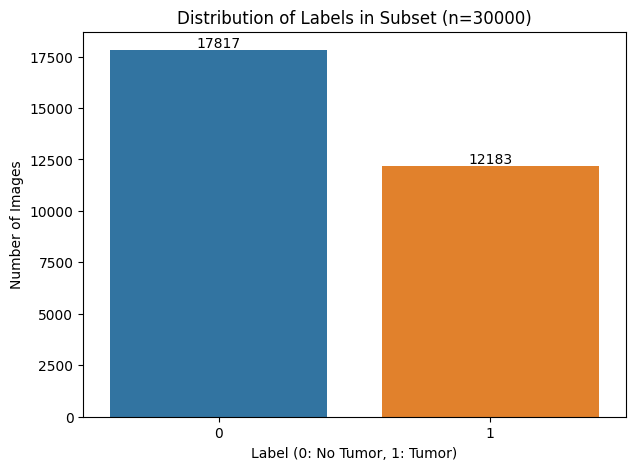


--- Sample Images from Subset ---


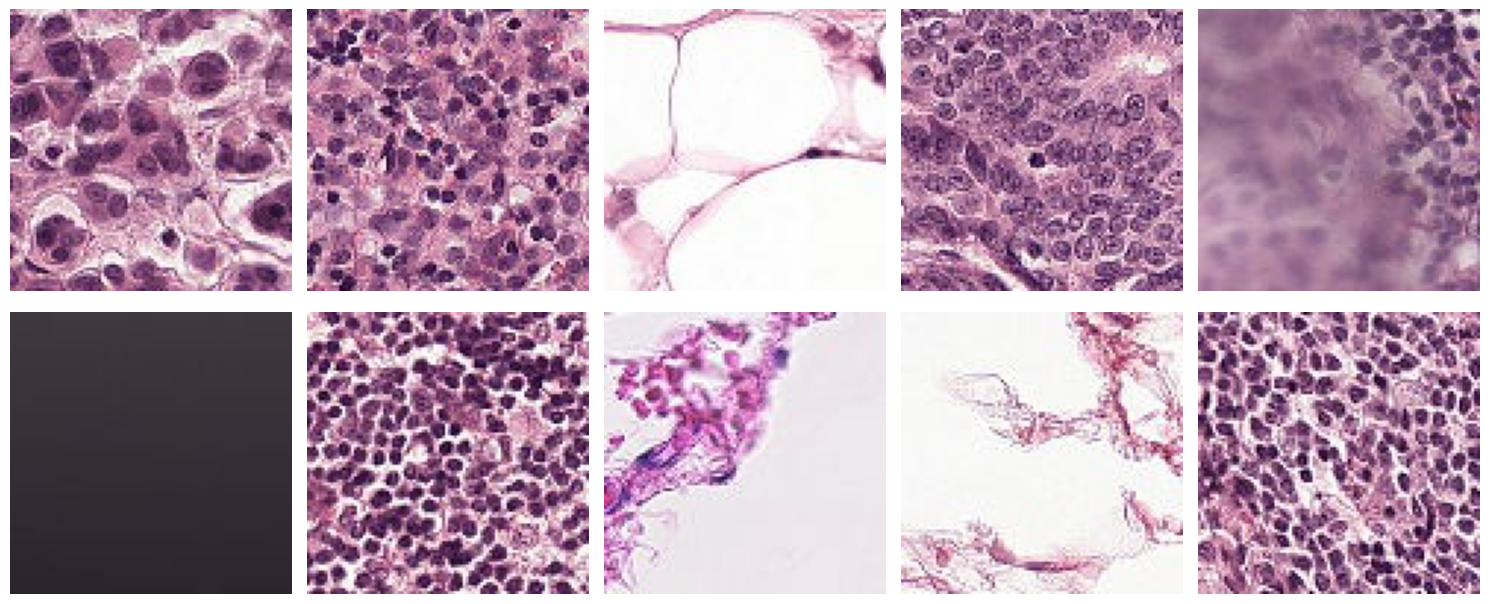


--- Data Cleaning Notes ---
1. Missing Values: Checked above, none found in the subset's labels/IDs.
2. Label Consistency: Labels seem to be just 0 and 1.
3. Duplicates: The Kaggle dataset description says duplicates were removed.
Basic cleaning seems okay for this dataset.


In [2]:
# --- Inspect Data ---
print("First 5 rows of the subset labels:")
print(labels_df.head())

print("\nData types and missing values in subset:")
labels_df[['id', 'label', 'filename', 'label_str']].info()


# --- Visualize Label Distribution in Subset ---
print("\n--- Label Distribution in Subset ---")
plt.figure(figsize=(7, 5))

ax = sns.countplot(x='label', data=labels_df)
plt.title(f'Distribution of Labels in Subset (n={len(labels_df)})')
plt.xlabel('Label (0: No Tumor, 1: Tumor)')
plt.ylabel('Number of Images')

for container in ax.containers:
    ax.bar_label(container)
plt.show()


# --- Visualize Sample Images ---
print("\n--- Sample Images from Subset ---")
def plot_sample_images(df, image_dir, num_samples=10):
    positive_samples = df[df['label'] == 1].sample(min(num_samples // 2, len(df[df['label'] == 1])), random_state=1)
    negative_samples = df[df['label'] == 0].sample(min(num_samples // 2, len(df[df['label'] == 0])), random_state=1)
    sample_df = pd.concat([positive_samples, negative_samples])


    plt.figure(figsize=(15, 7))
    cols = 5
    rows = (len(sample_df) + cols - 1) // cols

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        img_id = row['id']
        label = row['label']
        img_path = os.path.join(image_dir, img_id + '.tif')

        plt.subplot(rows, cols, i + 1)
        # Use PIL to open the image
        with Image.open(img_path) as img:
            plt.imshow(np.array(img))
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

plot_sample_images(labels_df, TRAIN_DIR)

# --- Data Cleaning Notes ---
print("\n--- Data Cleaning Notes ---")
print("1. Missing Values: Checked above, none found in the subset's labels/IDs.")
print("2. Label Consistency: Labels seem to be just 0 and 1.")
print("3. Duplicates: The Kaggle dataset description says duplicates were removed.")
print("Basic cleaning seems okay for this dataset.")

## Preparing Data for the Model

Now we need to get the images ready for the neural network:
1.  **Split Data:** Divide our subset into a training set and a validation set.
2.  **Data Augmentation:** Create slightly modified versions of the training images (like rotating, flipping). This helps the model learn better and not just memorize the exact training images. We won't augment the validation images.
3.  **Data Generators:** Set up tools (ImageDataGenerator) that will load images from the folders batch by batch, apply augmentation (for training), and rescale pixel values.

In [3]:
# --- Split Data ---
train_df, valid_df = train_test_split(
    labels_df,
    test_size=0.20,
    random_state=42,
    stratify=labels_df['label']
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(valid_df)}")

# --- Data Augmentation & Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,   
    vertical_flip=True,     
    rotation_range=15       
)

# Validation generator: Only rescale
valid_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create the generators from our dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Training samples: 24000, Validation samples: 6000
Found 24000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.


## Model Architecture

For this project, I'll use **Transfer Learning** with **MobileNetV2**.

* **Transfer Learning:** Instead of starting from scratch, we use a model (MobileNetV2) that has already been trained on a huge dataset of images (ImageNet).
* **MobileNetV2:** This is a pre-trained model known for being relatively small and fast compared to some others like VGG16 or ResNet50, which makes it suitable for a quicker project.

**My Plan:**
1.  Load MobileNetV2 without its final classification layer (`include_top=False`).
2.  **Freeze** the layers of MobileNetV2. This means we won't update its learned weights during initial training. We only want to use its features.
3.  Add my own layers on top:
    * `GlobalAveragePooling2D`: Simplifies the features coming from MobileNetV2.
    * `Dropout`: Randomly ignores some neurons during training to help prevent overfitting (where the model just memorizes the training data).
    * `Dense`: A standard fully connected layer for learning combinations of features.
    * `Dense (output)`: The final layer with 1 neuron and a 'sigmoid' activation function. Sigmoid squishes the output to be between 0 and 1, representing the probability of the image having cancer (label 1).


In [4]:
# --- Build Model ---
# Load the base model (MobileNetV2)
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False
print(f"MobileNetV2 base model loaded. Trainable layers: {len(base_model.trainable_variables)}")
print("Base model is FROZEN.")

# Create the new model on top
inputs = keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
# Add our custom layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x) # Dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# Compile the model
print("Compiling the model...")
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary() # Print model architecture

I0000 00:00:1745779786.727640      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 base model loaded. Trainable layers: 0
Base model is FROZEN.
Compiling the model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training and Results
Now it's time to train the model using the training data generator. We'll also use the validation data generator to see how well the model performs on data it hasn't seen during training after each epoch.

I'll use some **Callbacks**:
* `EarlyStopping`: Stops training automatically if the validation AUC doesn't improve for a few epochs. This saves time and prevents overfitting. It will also restore the weights from the best epoch.
* `ReduceLROnPlateau`: Reduces the learning rate if the validation AUC stops improving. This can help the model fine-tune itself better.

In [5]:
# --- Train Model ---
history = None
print("\n--- Training the Model ---")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=4,           # Stop after 4 epochs of no improvement in val_auc
    mode='max',           # Maximize AUC
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,           # Reduce LR by factor of 5
    patience=2,           # Reduce LR after 2 epochs of no improvement
    min_lr=1e-6,          # Don't reduce LR below this value
    mode='max',
    verbose=1
)

# Calculate steps per epoch
steps_per_epoch_calc = train_generator.samples // BATCH_SIZE
validation_steps_calc = valid_generator.samples // BATCH_SIZE

# Ensure steps are at least 1
if steps_per_epoch_calc == 0:
    steps_per_epoch_calc = 1
if validation_steps_calc == 0:
    validation_steps_calc = 1


print(f"Starting training for {EPOCHS} epochs......")
print(f"Calculated steps per epoch: {steps_per_epoch_calc}, Calculated validation steps: {validation_steps_calc}")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("Training finito.")

# --- Evaluate Final Model on Validation Set ---
print("\n--- Evaluating Final Model (Restored Best Weights) ---")
# Use the full validation set for evaluation
final_eval = model.evaluate(valid_generator, steps=validation_steps_calc, verbose=1)
print(f"Validation Loss: {final_eval[0]}")
print(f"Validation Accuracy: {final_eval[1]}")
print(f"Validation AUC: {final_eval[2]}")


--- Training the Model ---
Starting training for 15 epochs......
Calculated steps per epoch: 750, Calculated validation steps: 187
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745779800.718557      96 service.cc:148] XLA service 0x7a0db8041f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745779800.719194      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745779801.658694      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/750 ━━━━━━━━━━━━━━━━━━━━ 2:57:11 14s/step - accuracy: 0.5312 - auc: 0.5675 - loss: 0.8037

I0000 00:00:1745779805.711958      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 226s 283ms/step - accuracy: 0.7914 - auc: 0.8622 - loss: 0.4568 - val_accuracy: 0.8413 - val_auc: 0.9157 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 126ms/step - accuracy: 0.8318 - auc: 0.9062 - loss: 0.3759 - val_accuracy: 0.8468 - val_auc: 0.9206 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 100s 132ms/step - accuracy: 0.8321 - auc: 0.9048 - loss: 0.3784 - val_accuracy: 0.8493 - val_auc: 0.9226 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 95s 125ms/step - accuracy: 0.8406 - auc: 0.9121 - loss: 0.3644 - val_accuracy: 0.8572 - val_auc: 0.9273 - val_loss: 0.3439 - learning_rate: 0.0010
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - accuracy: 0.8449 - auc: 0.9161 - loss: 0.3558 - val_accuracy: 0.8592 - val_auc: 0.9289 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 127ms/step - accuracy: 0.8467 

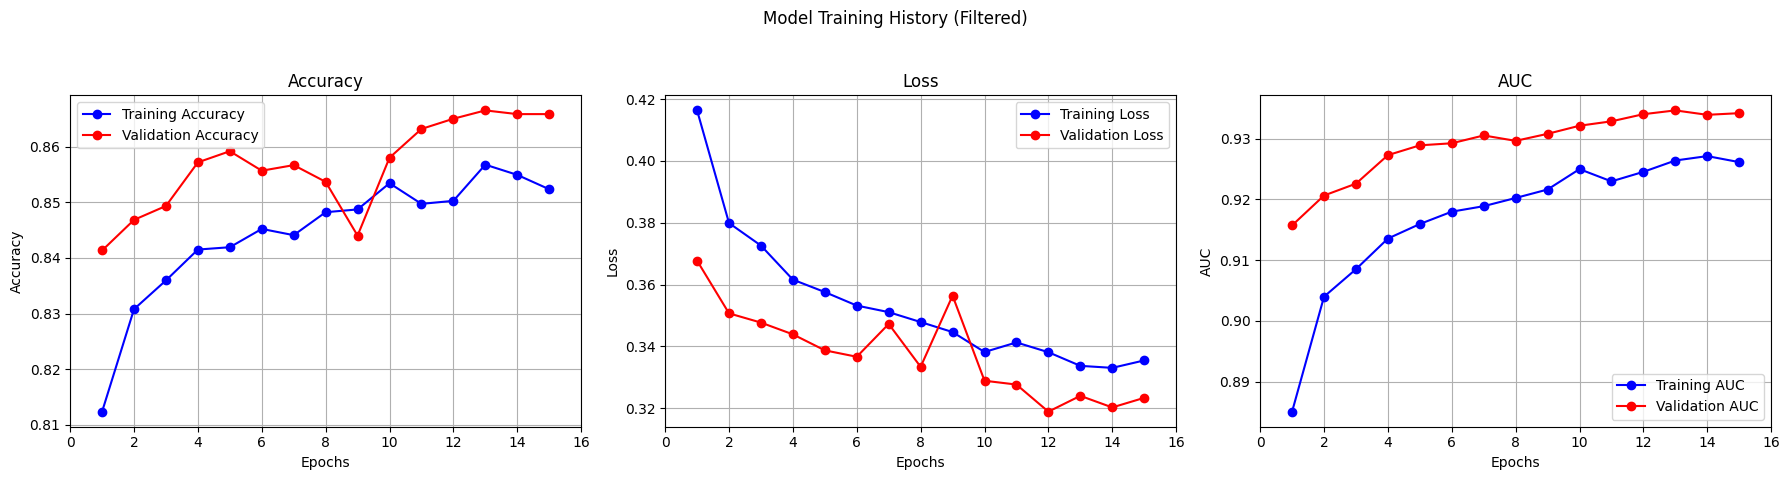

In [6]:
# --- Plot Results ---

# Get original history lists
acc_raw = history.history.get('accuracy', [])
loss_raw = history.history.get('loss', [])
auc_raw = history.history.get('auc', [])
val_acc = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])
val_auc = history.history.get('val_auc', [])

epochs_ran_filtered = range(1, len(acc) + 1)
epochs_ran_val = range(1, len(val_acc) + 1)


plt.figure(figsize=(18, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_ran_filtered, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_ran_val, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Set x-axis limits based on the number of actual epochs run
plt.xlim([0, len(acc) + 1])
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_ran_filtered, loss, 'bo-', label='Training Loss')
plt.plot(epochs_ran_val, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, len(loss) + 1])
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs_ran_filtered, auc, 'bo-', label='Training AUC')
plt.plot(epochs_ran_val, val_auc, 'ro-', label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.xlim([0, len(auc) + 1])
plt.legend()
plt.grid(True)

plt.suptitle('Model Training History (Filtered)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## Results, Analysis, and Conclusion

This project classified histopathologic images using transfer learning with a frozen MobileNetV2 base on a 30,000-image subset. Techniques included data augmentation and callbacks like `EarlyStopping` and `ReduceLROnPlateau`.

- **Performance:** The model achieved a **Validation AUC of 0.9346**, showing effective learning on the subset. However, the **Kaggle Public/Private AUC scores (0.8249 / 0.7797)** were lower, so there might have been some overfitting to the validation set or differences between the datasets.
    
- **Model:** Using MobileNetV2 provided a good base, while augmentation and dropout helped reduce overfitting. `EarlyStopping` saved training time and prevented further overfitting by restoring the best weights.
    
- **Learnings:** This project demonstrated the workflow for image classification, including using data generators for large datasets, applying transfer learning, and the importance of callbacks. However achieving better performance requires careful tuning and often more data/compute.
    
- **Future Improvements:** To potentially improve the Kaggle score, next steps could include:
    
    - Training on the full dataset.
        
    - Experimenting with fine-tuning (unfreezing later MobileNetV2 layers with a low learning rate).
        
    - Trying different architectures or more advanced augmentation.
        
    - More systematic hyperparameter tuning.